# Quantum Proof of Work: q-circuit with parametric quantum gates
#### code developed by Mikhail Shalaginov (mys@mit.edu), Michael Dubrovsky (mike@powx.org), and Maximus Liu (maximusliu2004@gmail.com)

Proof of work (PoW) is the mechanism allowing formation of decentralized cryptocurrency blockchains (e.g. Bitcoin). Here we introduce a quantum computing part to a traditional mining cycle in a similar way as it has been proposed earlier for <a href="https://assets.pubpub.org/xi9h9rps/01581688887859.pdf">optical PoW</a>. The QPoW cycle is illustrated on a schematic below. 

The input ('text') is a concatenated string containing: nonce, transaction data and a hash-string from a previous run. Nonce is an integer starting from 0 value and incrementing by 1 with each cycle, transaction data is a ledger entry, e.g. <font color='green'>'Schroedinger paid Einstein 1 qBTC'</font>. By SHA3 algorithm the 'text' (e.g. <font color='green'>'4Schroedinger paid Einstein 1 qBTC04ca1a782621a440d03b5d87ecff8b68e2cc6124f57957b49a76bca91dede3a81'</font>) is transformed into a 256-bit hash-string (<font color='green'>'e1e5575da3a9e86da135552facddcc1ff44dd26502d0bc2b22961383f8b187ca'</font>) that is pushed through the QPoW stages. After all of the computations, we have a 256-bit hash-string as an output(<font color='green'>'f307b3db12a649563831e3e1328c3c7a5b15ee541afaab563727cb992cf9d1ca'</font>). If the output satisfies the conditions set by the task difficulty, i.e. the output string has a certain number of zeros, then the block is reported to be successfully found. Otherwise, the output hash feeds back into the input 'text' and the nonce is increased by 1. When the block is finally found, it goes through a verification test performed by a quantum simulator ran on a classical computer.

In this demo we demonstrate the construction of a block-chain composed of several elements by computing the quantum algorithm on a simulated 18-qubit IBM Q node (<a href="https://quantum-computing.ibm.com/">ibm_peekskill</a>).

<img src="images/QPoW_schematic2.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="1200 px" align="center">

In [36]:
# import modules for Qiskit
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, BasicAer, Aer, IBMQ, execute, schedule
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer import AerSimulator
import qiskit.providers.aer.noise as Noise
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager

import numpy as np
np.set_printoptions(precision=3)
from  IPython.core.display import display

# import modules for SHA
import sys
import hashlib
import numpy as np
import random

if sys.version_info < (3, 6):
	import sha3

# import other useful packages 
from numpy import pi
from datetime import date
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time

### Noise model

In [44]:
# True if you have access to IBM hardware, False if you want to create a custom noise model
use_real_hardware = False

if(use_real_hardware == True):
# code for getting the backend and noise model from hardware
# use this code for either more accurate noise simulations or actual quantum computer runs.

    print("Getting provider...")
    if not IBMQ.active_account():
        IBMQ.load_account()
    provider = IBMQ.get_provider()

    global backend, noise_model

    def select_backend():
        """
        select_backend allows the use to choose an IBM quantum computer as a backend

        :return: None
        """
        # Get all available and operational backends.
        available_backends = provider.backends(filters=lambda b: not b.configuration().simulator and b.configuration().n_qubits > 1 and b.status().operational)
        
        # Fish out criteria to compare
        print("{0:20} {1:<10} {2:<10}".format("Name","#Qubits","Pending jobs"))
        print("{0:20} {1:<10} {2:<10}".format("----","-------","------------"))
            
        for n in range(0, len(available_backends)):
            backend = provider.get_backend(str(available_backends[n]))
            print("{0:20} {1:<10}".format(backend.name(),backend.configuration().n_qubits),backend.status().pending_jobs)

        select_backend=input("Select a backend ('exit' to end): ")
        
        if select_backend!="exit":
            backend = provider.get_backend(select_backend)
        else:
            backend=select_backend
        return(backend)

    def build_noise_model(backend):
        """
        build_noise_model builds a noise model based on the backend
        
        :param backend: the backend that is used to build the noise model
        :return: the noise model for noise simulation
        """

        noise_model = NoiseModel.from_backend(backend)
        return(noise_model)
    
    # parameters needed to run a noise model
    # if using a real quantum computer, only the backend is used
    backend = select_backend()
    noise_model = build_noise_model(backend)
    basis_gates = noise_model.basis_gates
    coupling_map = backend.configuration().coupling_map

else:
    # makeshift noise simulator
    try:
        del sys.modules['data_to_noise_simulator']
    except:
        from data_to_noise_simulator import data_to_noise_simulator
    else:
        from data_to_noise_simulator import data_to_noise_simulator

    noise_model, coupling_map = data_to_noise_simulator(bit_flip = True, thermal_relaxation = True)

    basis_gates = ['cx', 'id', 'sx', 'x', 'rz']

Select a backend: ibm_peekskill


In [47]:
folder=input("Folder to write files to: ")
if(not os.path.isdir(str(folder))):
    os.makedirs(str(folder))
filepath = os.getcwd()+'/'+str(folder)+'/' #specify data storage folder
    
# settings for IBM Q backends
# TOKEN = ''
# IBMQ.save_account(TOKEN)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
simulator_name = 'qasm_simulator'

# parameters
numberOfcalcs = 100
MAX_NONCE = 2**32

# input parameters
previous_hash = '' # empty hash
block_number = 0
transactions ='Schroedinger paid Einstein 1 qBTC'
n_qreg_list = [20] # list of the numbers of qubits to experiment with
num_states = 2620
num_intersection = 100

# list of errors for each number of qubits
error_list = [0]*len(n_qreg_list)


# QPoW cycle: function takes the input text (block number, nonce,...) and pushes it through once 

def qPoW(text, quantum_circuit, errors, num_states, num_intersection):
    """
    qPoW takes the input text and pushes it through once, and it updates the array of errors

    :param text: the text that is hashed and used to parameterize the quantum circuit
    :param quantum_circuit: the function to build the parameterized quantum circuit
    :param errors: the array of errors for different percentages of maxstates and overlap requirements
    :param num_states: the maximum number of states considered
    :param num_intersection: the number of overlap percentages considered (from 0% to 100%)
    :return: the updated error array
    """
    hashIn = hashlib.sha3_256(text.encode("ascii")).hexdigest() # hashing the 'text' input
    #string-type output

    print ('hashIn-hex:', hashIn, 'length:', len(hashIn))

    # convert hashIn(hex) to hashIn_bin(binary)
    scale = 16 # hex base
    hashIn_bin = bin(int(hashIn, scale))[2:].zfill(len(hashIn)*4)
    print ('hashIn-binary:', str(hashIn_bin), 'length:', len(hashIn_bin))

    # comparison of the results produced by quantum simulator and quantum computer
    qstate_bin_sim = sim_quantum_operation(quantum_circuit, hashIn_bin, num_states)
    qstate_bin_exp = exp_quantum_operation(quantum_circuit, hashIn_bin, num_states) #qstate is a 256 binary number

    # error rate calculation
    for states in range(1, num_states+1):
        maxstates_sim = set(qstate_bin_sim[:states])
        maxstates_exp = set(qstate_bin_exp[:states])
        overlap_val = math.ceil(overlap(maxstates_sim, maxstates_exp)*num_intersection/states+1e-20)
        errors[states][overlap_val:num_intersection+1]+=1
    return errors

def overlap(maxstates_sim, maxstates_exp):
    """
    overlap calculates the overlap between two sets

    :param maxstates_sim: the set of states from the simulation
    :param maxstates_exp: the set of states from the noise simulator or quantum computer
    :return: the number of overlapping states
    """
    return len(maxstates_sim.intersection(maxstates_exp))
    
# converting hashIn_bin to a bit string to pass thru a quantum processor
def break_up_4bit_values(hashIn_bin):
    """
    break_up_4bit_values converts the input into an array of 4-bit strings

    :param hashIn_bin: the binary string that is broken up
    :return: array of 4-bit strings
    """
    array_4_bit_values = []

    for i in range(64): 
      four_bits = hashIn_bin[2+4*i:2+4*i+4]
      array_4_bit_values.append(four_bits)
        
    print("hashIn binary split into 4bit bins:", array_4_bit_values)
    return array_4_bit_values

def quantum_circuit(q_par, n_qreg, circ_layer = 1):
    """
    quantum_circuit builds a paramterized quantum circuit

    :param q_par: the parameters
    :param n_qreg: the number of qubits
    :param circ_layer: the number of times to repeat the circuit
    :return: the quantum circuit
    """
    k = 0 # counter for the parameter values
    
    # circuit 15
    # setting the quantum circuit:
    qreg_q = QuantumRegister(n_qreg, 'q')
    creg_c = ClassicalRegister(n_qreg, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)
    for layer in range(circ_layer):

        for i in range(n_qreg):   
            circuit.ry(pi/2, qreg_q[i])

        for i in range(1, n_qreg):
            circuit.crx(q_par[k+i]*pi/8, qreg_q[n_qreg-i-1], qreg_q[(n_qreg-i)%n_qreg])
        k+=n_qreg
        
        for i in range(n_qreg):
            circuit.ry(pi/2, qreg_q[i])
        
        for i in range(1, n_qreg):
            circuit.crx(q_par[k+i]*pi/8, qreg_q[(n_qreg-1+i)%n_qreg], qreg_q[(n_qreg-2+i)%n_qreg])
        k+=n_qreg

    # measurements of all qubits
    for i in range(n_qreg):
        circuit.measure(qreg_q[i], creg_c[i])

    return circuit


def exp_quantum_operation(quantum_circuit, hashIn, num_states, use_noise_model = False):
    """
    exp_quantum_operation runs the paramterized circuit with either a noise simulator or a real quantum computer

    :param quantum_circuit: function that returns the desired quantum circuit
    :param hashIn: the SHA3-256 hash of the input string
    :param num_states: the maximum number of states considered
    :param use_noise_model: whether to use the noise model or the real quantum computer
    :return: the top num_states output states in an array
    """
    # input hashIn string
    fourbit_array = break_up_4bit_values(hashIn)
    q_par = [int(fourbit_array[i],2) for i in range(len(fourbit_array)-1)] #throwing away the last string element
    circuit = quantum_circuit(q_par, n_qreg)
    
    if(use_noise_model):
        ######## Real quantum computer runs ########
        # noise model not used
        transpiled_circuit = transpile(circuit, backend, seed_transpiler=13)
        qpu_job = backend.run(transpiled_circuit, shots=20000)
        job_id = qpu_job.job_id()
        job_monitor(qpu_job)
        results = qpu_job.result()
    else:
        ######## Noise simulator runs ########
        # noise model used
        backend = Aer.get_backend(simulator_name)
        job = execute(circuit, backend, noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
        job_monitor(job)
        results = job.result()

    counts = results.get_counts(circuit)

    # picking up the maximally probable states
    max_state256 = sorted(counts, key=counts.get, reverse=True)[:num_states]
    
    return max_state256 # 4bit vector

# quantum simulator run
def sim_quantum_operation(quantum_circuit, hashIn, num_states):
    """
    sim_quantum_operation runs the paramterized circuit with the qasm simulator

    :param quantum_circuit: function that returns the desired quantum circuit
    :param hashIn: the SHA3-256 hash of the input string
    :param num_states: the maximum number of states considered
    :return: the top num_states output states in an array
    """
    # input hashIn string
    fourbit_array = break_up_4bit_values(hashIn)
    q_par = [int(fourbit_array[i],2) for i in range(len(fourbit_array)-1)] #throwing away the last string element
    circuit = quantum_circuit(q_par, n_qreg)

    backend = BasicAer.get_backend(simulator_name) # run on local simulator by default 

    job = execute(circuit, backend, shots=20000)

    # Monitor job progress and wait until complete:
    job_monitor(job)

    # Get the job results (this method also waits for the job to complete):
    results = job.result()
    
    counts = results.get_counts(circuit)

    # picking up the maximally probable states
    max_state256 = sorted(counts, key=counts.get, reverse=True)[:num_states]

    return max_state256 # 4bit vector

for i in range(len(n_qreg_list)):
    n_qreg = n_qreg_list[i]
    counter = 1
    errors = np.zeros((num_states+1, num_intersection+1)) # number of 'False' nonces
    while counter <= numberOfcalcs:

        ### Execute both exp and qPoW
        nonce = random.randint(0, MAX_NONCE)
        print('nonce:', nonce, '\n') 
        text = str(block_number) + transactions + previous_hash + str(nonce) #hash input
        print('text:', text, '\n')

        errors = qPoW(text, quantum_circuit, errors, num_states, num_intersection)
        error_rate = np.array(errors)/counter

        print('error rate: ' + str(error_rate))
        print(counter)
        counter+=1
    error_list[i] = error_rate
for x in error_list:
    print(x)

Folder to write files to: ibm_peekskill_custom_loop_20qubit


ibmqfactory.load_account:WARNING:2022-11-03 07:39:57,438: Credentials are already in use. The existing account in the session will be replaced.


nonce: 3793684245 

text: 0Schroedinger paid Einstein 1 qBTC3793684245 

hashIn-hex: 6aa5a21d941e069eff946fef5aae98280cbb151ea5e9d18a603e3f5ad287af80 length: 64
hashIn-binary: 0110101010100101101000100001110110010100000111100000011010011110111111111001010001101111111011110101101010101110100110000010100000001100101110110001010100011110101001011110100111010001100010100110000000111110001111110101101011010010100001111010111110000000 length: 256
hashIn binary split into 4bit bins: ['1010', '1010', '1001', '0110', '1000', '1000', '0111', '0110', '0101', '0000', '0111', '1000', '0001', '1010', '0111', '1011', '1111', '1110', '0101', '0001', '1011', '1111', '1011', '1101', '0110', '1010', '1011', '1010', '0110', '0000', '1010', '0000', '0011', '0010', '1110', '1100', '0101', '0100', '0111', '1010', '1001', '0111', '1010', '0111', '0100', '0110', '0010', '1001', '1000', '0000', '1111', '1000', '1111', '1101', '0110', '1011', '0100', '1010', '0001', '1110', '1011', '1110', '0000', '00']
Job Stat

KeyboardInterrupt: 

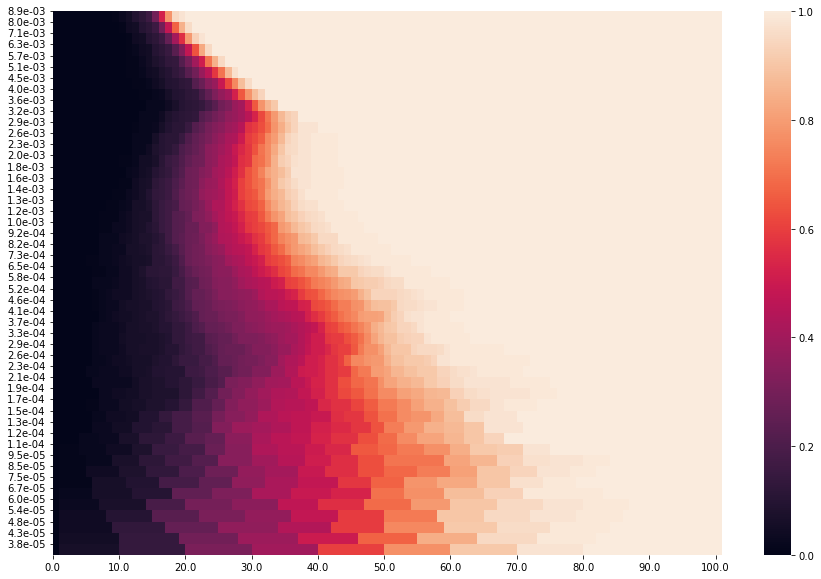

In [46]:
numxticks = 10
scale_down_factor = 1
xaxis_logscale = False

for i in range(len(n_qreg_list)):
    n_qreg = n_qreg_list[i]
    plt.figure(figsize=(15,10))
    if(xaxis_logscale):
        log_num_intersection = int(math.log10(num_intersection))
        xaxis = np.array([int(10**i) for i in np.linspace(0, log_num_intersection, numxticks+1)])
        xaxis_labels = np.array(["{:.1e}".format(10**(i-numxticks+2)) for i in np.linspace(0, log_num_intersection, numxticks+1)])
        yaxis = np.array([int(10**i) for i in np.linspace(math.log10(num_states-1), math.log10(10), 50)])
        yaxis_labels = np.array(["{:.1e}".format(10**i) for i in np.linspace(math.log10((num_states-1)/(2**n_qreg)), math.log10(10/(2**n_qreg)), 50)])

        error_arr = error_list[i][yaxis][:, xaxis]
        ax = sns.heatmap(error_arr, vmin = 0, vmax = 1)

        ax.xaxis.set_ticks(range(numxticks+1))
        ax.xaxis.set_ticklabels(xaxis_labels)
        ax.yaxis.set_ticks(range(len(yaxis))[::-1])
        ax.yaxis.set_ticklabels(yaxis_labels[::-1])
    else:
        xaxis = np.array(range(num_intersection//scale_down_factor+1))
        yaxis = np.array([int(10**i) for i in np.linspace(math.log10(num_states-1), math.log10(10), 50)])
        yaxis_labels = np.array(["{:.1e}".format(10**i) for i in np.linspace(math.log10((num_states-1)/(2**n_qreg)), math.log10(10/(2**n_qreg)), 50)])

        error_arr = error_list[i][yaxis][:, xaxis]
        ax = sns.heatmap(error_arr, vmin = 0, vmax = 1)

        ax.xaxis.set_ticks(xaxis[::num_intersection//scale_down_factor//numxticks])
        ax.xaxis.set_ticklabels(100//scale_down_factor/numxticks*np.array(range(numxticks+1)))
        ax.yaxis.set_ticks(range(len(yaxis))[::-1])
        ax.yaxis.set_ticklabels(yaxis_labels[::-1])
    plt.xticks(rotation=0)
    plt.yticks(rotation=0) 
    plt.ylim(50, 1)

    plt.savefig(filepath + 'heatmap' + str(n_qreg_list[i]) + 'qubits.png')
    plt.show()

In [5]:
error_arr

array([[0.  , 0.  , 0.  , ..., 1.  , 1.  , 1.  ],
       [0.  , 0.  , 0.  , ..., 1.  , 1.  , 1.  ],
       [0.  , 0.  , 0.  , ..., 1.  , 1.  , 1.  ],
       ...,
       [0.  , 0.33, 0.33, ..., 1.  , 1.  , 1.  ],
       [0.  , 0.39, 0.39, ..., 1.  , 1.  , 1.  ],
       [0.  , 0.41, 0.41, ..., 1.  , 1.  , 1.  ]])

In [31]:
def calc_optimal_parameters(error_arr, n_qreg):
    best_param = (-1, -1)
    for i in range(len(error_arr)):
        for j in range(0, len(error_arr[i])-1):
            if(error_arr[i][j] <= 0.00):
                if(error_arr[i][j+1] > 0.00 and j >= best_param[1]):
                    best_param = (i, j)
            else:
                break
    return best_param

In [32]:
calc_optimal_parameters(error_list[0], 18)

(1499, 4)

In [8]:
def calc_probability_random_guess(num_states, num_intersection, n_qreg):
    """
    calc_probability_random_guess finds the probability that a randomly chosen set of 
    num_states states will have at least num_intersection overlap with another set of num_states
    
    :param num_states: the number of states
    :param num_intersection: the number of overlaps required
    :param n_qreg: the number of qubits
    :return: the exact probability
    """
    numerator = 0
    denominator = math.comb(2**n_qreg, num_states)
    for i in range(num_intersection, num_states+1):
        numerator += math.comb(num_states, i)*math.comb(2**n_qreg-num_states, num_states-i)
    return numerator/denominator

def approximate_probability_random_guess(num_states, num_intersection, n_qreg):
    """
    calc_probability_random_guess finds the probability that a randomly chosen set of 
    num_states states will have at least num_intersection overlap with another set of num_states
    
    :param num_states: the number of states
    :param num_intersection: the number of overlaps required
    :param n_qreg: the number of qubits
    :return: the approximate probability
    """
    prob = 0
    ln_denominator = ln_approx_comb(2**n_qreg, num_states)
    for i in range(num_intersection, num_states+1):
        exponent = ln_approx_comb(num_states, i)+ln_approx_comb(2**n_qreg-num_states, num_states-i)-ln_denominator
        prob += math.exp(exponent)
    return prob

def logf(n):
    """
    logf is a helper function
    
    :return: an approximation of the logarithm of n factorial
    """
    if(n == 0):
        return 0
    return (n - 0.5) * math.log(n) - n + 0.5 * math.log(2 * pi) + 1/(12 * n)

def ln_approx_comb(n, k):
    """
    approx_comb is a helper function
    
    :param n: n
    :param k: k
    :return: ln(n choose k)
    """
    if(n == k):
        return 1
    return logf(n) - logf(n - k) - logf(k)

In [33]:
start = time.perf_counter()
print(calc_probability_random_guess(1499, 60, 18))
end = time.perf_counter()
print(end-start)

4.3408634741180095e-31
1.0147898000432178


In [34]:
start = time.perf_counter()
print(approximate_probability_random_guess(1499, 60, 18))
end = time.perf_counter()
print(end-start)

2.4061513595546857e-29
0.006835500011220574
